In [1]:
import pylab
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import yeojohnson
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

## Nifty index values for a year during normal market

In [2]:
data = pd.read_csv("normal market.csv")
print("Nifty between {} to {}".format(data["Date"].iloc[0],data["Date"].iloc[-1]))
data

Nifty between 01-Aug-16 to 31-Jul-17


,Date,Price,Open,High,Low,Volume,Chg%
0,01-Aug-16,8636.55,8654.30,8711.30,8590.50,194.19M,-0.02%
1,02-Aug-16,8622.90,8647.45,8687.20,8611.40,174.56M,-0.16%
2,03-Aug-16,8544.85,8635.20,8635.45,8529.60,168.03M,-0.91%
3,04-Aug-16,8551.10,8599.95,8601.40,8518.15,169.78M,0.07%
4,05-Aug-16,8683.15,8600.20,8689.40,8590.15,162.78M,1.54%
...,...,...,...,...,...,...,...
243,25-Jul-17,9964.55,10010.55,10011.30,9949.10,191.21M,-0.02%
244,26-Jul-17,10020.65,9983.65,10025.95,9965.95,203.70M,0.56%
245,27-Jul-17,10020.55,10063.25,10114.85,10005.50,296.78M,0.00%
246,28-Jul-17,10014.50,9996.55,10026.05,9944.50,197.49M,-0.06%


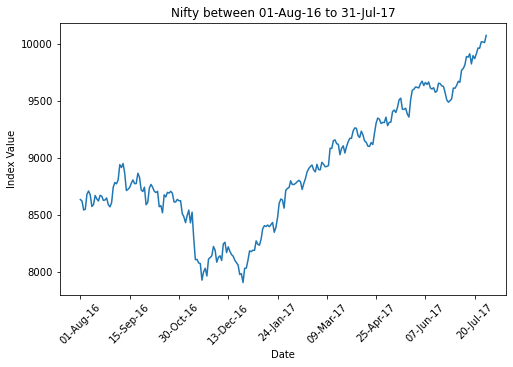

In [3]:
plt.figure(figsize=(8, 5))
plt.plot(data["Date"],data["Price"])
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("Nifty between {} to {}".format(data["Date"].iloc[0],data["Date"].iloc[-1]))
ax=plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.show()

In [4]:
# Calculating log return of index
data["LogReturn"] = np.log(data["Price"]).shift(-1) - np.log(data["Price"])
data.dropna(inplace=True)
print("Number of rows: {}".format(data.shape[0]))
data.head(5)

Number of rows: 247


,Date,Price,Open,High,Low,Volume,Chg%,LogReturn
0,01-Aug-16,8636.55,8654.30,8711.30,8590.50,194.19M,-0.02%,-0.001582
1,02-Aug-16,8622.90,8647.45,8687.20,8611.40,174.56M,-0.16%,-0.009093
2,03-Aug-16,8544.85,8635.20,8635.45,8529.60,168.03M,-0.91%,0.000731
3,04-Aug-16,8551.10,8599.95,8601.40,8518.15,169.78M,0.07%,0.015324
4,05-Aug-16,8683.15,8600.20,8689.40,8590.15,162.78M,1.54%,0.003242


## Distribution of Index log-returns

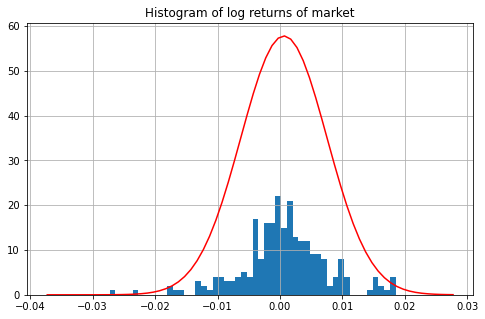

In [5]:
mu = data["LogReturn"].mean()
sigma = data["LogReturn"].std(ddof=1)

density = pd.DataFrame()
density["x"] = np.arange(data["LogReturn"].min()-0.01, data["LogReturn"].max()+0.01, 0.001)
density["pdf"] = norm.pdf(density["x"], mu, sigma)

data["LogReturn"].hist(bins=50, figsize=(8, 5))
plt.plot(density["x"], density["pdf"], color="red")
plt.title("Histogram of log returns of market")
plt.show()

## Checks for normality of distribution

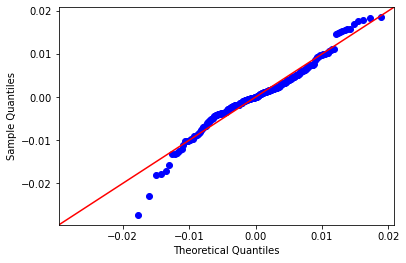

In [6]:
# QQ plot
qqplot(data["LogReturn"], loc=mu, scale=sigma, line="45")
plt.show()

In [7]:
# Shapiro Wilk normality test
# H0: Distribution is normal

stat, p = shapiro(data["LogReturn"])
print("Statistics = {:.3f}, p = {:.3f}".format(stat, p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

Statistics = 0.969, p = 0.000
Sample does not look normally distributed (reject H0)


In [8]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# Normality test based on D’Agostino and Pearson’s test

k2, p = normaltest(data["LogReturn"])
print("p = {}".format(p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

p = 0.00045243775826893975
Sample does not look normally distributed (reject H0)


**The distribution does not seem to be distributed normally. Hence, I have now tried some transformation to try to fit into normal distribution**

## Data transformation to fit normal distribution

**Yeo Johnson** transformation ([https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.yeojohnson.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.yeojohnson.html))

In [9]:
# Yeo Johnson transformation
xt, lmbda_opt = yeojohnson(data["LogReturn"])

In [10]:
# Difference between original log returns and transformed values
temp = pd.DataFrame(data["LogReturn"])
temp["After transformation"] = pd.Series(xt)
temp.head()

,LogReturn,After transformation
0,-0.001582,-0.001571
1,-0.009093,-0.008747
2,0.000731,0.000733
3,0.015324,0.016377
4,0.003242,0.003288


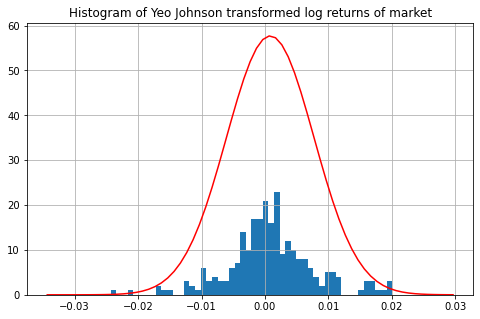

In [11]:
mu_n = xt.mean()
sigma_n = xt.std(ddof=1)

density = pd.DataFrame()
density["x"] = np.arange(xt.min()-0.01, xt.max()+0.01, 0.001)
density["pdf"] = norm.pdf(density["x"], mu_n, sigma_n)

pd.Series(xt).hist(bins=50, figsize=(8, 5))
plt.plot(density["x"], density["pdf"], color="red")
plt.title("Histogram of Yeo Johnson transformed log returns of market")
plt.show()

## Check for normality after transformation

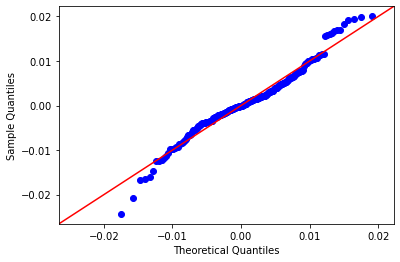

In [12]:
# QQ plot after transformation
qqplot(xt, loc=mu_n, scale=sigma_n, line="45")
plt.show()

In [13]:
# Shapiro Wilk test
# H0: Distribution is normal

stat, p = shapiro(xt)
print("Statistics = {:.3f}, p = {:.3f}".format(stat, p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

Statistics = 0.972, p = 0.000
Sample does not look normally distributed (reject H0)


In [14]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# Normality test based on D’Agostino and Pearson’s test

k2, p = normaltest(xt)
print("p = {}".format(p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

p = 0.00925613981380398
Sample does not look normally distributed (reject H0)


**After the transformation, the data -----------------------------**

## Probabilities of losses, VaR, SD

In [15]:
# Probability that the index will drop over 5% in a day
prob_return1 = norm.cdf(-0.05, mu_n, sigma_n)
print("The Probability is {:.5f}".format(prob_return1))

The Probability is 0.00000


In [16]:
# Probability that the index will drop over 10% in a day
prob_return1 = norm.cdf(-0.10, mu_n, sigma_n)
print("The Probability is {:.5f}".format(prob_return1))

The Probability is 0.00000


In [17]:
# Drop over 40% in 248 days
mu248 = 248*mu_n
sigma248 = (248**0.5) * sigma_n
print("The probability of dropping over 40% in 248 days is {:.5f}".format(norm.cdf(-0.4, mu248, sigma248)))

The probability of dropping over 40% in 248 days is 0.00000


In [18]:
# Drop over 20% in 248 days
mu248 = 248*mu_n
sigma248 = (248**0.5) * sigma_n
print("The probability of dropping over 20% in 248 days is {:.5f}".format(norm.cdf(-0.2, mu248, sigma248)))

The probability of dropping over 20% in 248 days is 0.00010


In [19]:
# 1-day 5% Value at Risk (VaR)
print("1-day 5% Value at Risk (VaR) (using normal distribution): {:.4f}%".format(norm.ppf(0.05, mu_n, sigma_n)*100))

logr = data["LogReturn"].sort_values(ascending=True, ignore_index=True)
print("1-day 5% Value at Risk (VaR) (using data): {:.4f}%".format(logr.iloc[round(logr.size*0.05)]*100))

1-day 5% Value at Risk (VaR) (using normal distribution): -1.0542%
1-day 5% Value at Risk (VaR) (using data): -1.0249%


In [20]:
print("SD of original index return: {:.4f}%".format(data["LogReturn"].std(ddof=1)*100))
print("SD of transformed index return: {:.4f}%".format(xt.std(ddof=1)*100))

SD of original index return: 0.6905%
SD of transformed index return: 0.6914%
